# 04 Demonstration of API to get flux limits

## Set up and finding the flux limits

After installing the HETDEX API we can import the tools to read the
HDF5 sensivity cube containers

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.table import Table

from hetdex_api.survey import Survey
from hetdex_api.flux_limits.hdf5_sensitivity_cubes import (SensitivityCubeHDF5Container, 
                                                           return_sensitivity_hdf_path)
# has to be here, as SensitivityCube sets a backend
%matplotlib inline

The sensitivity cube class expects the full path to the HDF file containing the flux limits for a given shot. A simple function is provided to generate the file path from a given datevobs, so to start we need to pick a datevobs. Let's use the survey table, as described in the first notebook.

In [2]:
survey = Survey("hdr2.1")
survey_table = survey.return_astropy_table()
survey_table[-10:]

shotid,field,objid,date,obsid,ra,dec,pa,n_ifu,fwhm_virus,fwhm_virus_err,response_4540,ambtemp,datevobs,dewpoint,exptime,humidity,mjd,nstars_fit_fwhm,obsind,pressure,structaz,time,trajcdec,trajcpa,trajcra,shot_flag,fluxlimit_4540
int64,bytes12,bytes18,int32,int32,float64,float64,float64,int32,float32,float32,float32,float32,bytes12,float32,float32,float32,float32,int32,int32,float32,float32,bytes7,float32,float32,float32,bool,float64
20200625017,dex-spring,DEXsp4017,20200625,17,210.738079,54.380782,299.624902,70,2.7147236,0.7351299,0.0657,19.393888,20200625v017,8.528889,427.93527,46.422,59025.22,140,1,804.5381,323.24152,0517466,54.38,297.93137,210.738,True,3.4022886355000006e-16
20200625018,dex-spring,DEXsp3967,20200625,18,220.267192,53.446167,299.593584,70,1.9157426,0.565008,0.1493,19.396667,20200625v018,8.218889,607.68256,46.019,59025.24,16,1,804.5381,323.24152,0545172,53.446377,297.93137,220.26654,True,1.0518607855000001e-16
20200625019,dex-spring,DEXsp7185,20200625,19,231.379347,53.476017,299.621378,70,1.9826775,0.25718248,0.1344,19.47,20200625v019,7.553889,367.87448,42.96,59025.266,27,1,804.301,323.24152,0621492,53.475475,297.93137,231.37999,True,9.963181855e-17
20200625020,dex-spring,DEXsp6525,20200625,20,234.140324,53.98981,299.617724,70,1.8120736,0.32785416,0.1523,19.15611,20200625v020,7.5394444,487.69955,43.635,59025.28,37,1,804.301,323.24152,0645237,53.989723,297.93137,234.13976,True,9.209148355000002e-17
20200625021,dex-spring,DEXsp6671,20200625,21,240.172723,53.54772,299.621378,70,1.6585162,0.38814068,0.1324,19.146667,20200625v021,7.551111,488.26645,43.714,59025.3,21,1,804.3688,323.24152,0715209,53.547062,297.93137,240.1725,True,9.047872855000001e-17
20200626016,dex-spring,DEXsp7175,20200626,16,230.675762,53.234764,296.974196,71,1.2604536,0.10521854,0.1537,20.10389,20200626v016,9.031111,427.66614,46.533,59026.246,43,1,804.6397,321.002,0554075,53.234367,295.3104,230.67612,True,5.863015855000002e-17
20200626017,dex-spring,DEXsp7111,20200626,17,224.852859,53.549799,296.932937,71,1.3909405,0.2306041,0.1123,19.631666,20200626v017,9.708889,367.5492,49.958,59026.266,25,1,804.7074,321.002,0622044,53.549393,295.3104,224.85326,True,7.762371355000001e-17
20200626018,dex-spring,DEXsp6508,20200626,18,233.651753,53.993989,296.924724,71,1.4448333,0.23766221,0.1245,19.502777,20200626v018,10.167222,367.12317,51.678,59026.28,38,1,804.7074,321.00192,0647072,53.993607,295.3103,233.65271,True,7.803667855000001e-17
20200626019,dex-spring,DEXsp6618,20200626,19,239.174074,53.113723,296.973253,71,1.3604825,0.2726477,0.1043,19.17389,20200626v019,11.966666,367.45407,53.376,59026.3,27,1,804.6397,321.00192,0711352,53.113827,295.3103,239.17342,True,8.676019855000001e-17


Let pick datevobs ``20190209v024`` as an example. We'll load the latest version, and also some HDR1 data to show how to access old releases. We'll also load the filename of the new spatial masks, and the shot ``20190108v013``
as an example of data with masking.

In [3]:
datevobs = "20190209v024"
datevobs_with_bad_data = "20190108v013"
hdf_filename_hdr1 = return_sensitivity_hdf_path(datevobs, release="hdr1")
hdf_filename_hdr2pt1, mask_fn = return_sensitivity_hdf_path(datevobs, release="hdr2.1", return_mask_fn=True)
hdf_filename_hdr2pt1_bad, mask_fn_bad = return_sensitivity_hdf_path(datevobs_with_bad_data, release="hdr2.1", \
                                                                    return_mask_fn=True)

## New: Choosing your data release model

New for HDR2.1, you can now specify a `flim_model`. This lets you chose which model you want for the flux limits. Available so far are `hdr1` and `hdr2pt1`. The default is `hdr2pt1`, the `hdr1` model should give you the same results as the HDR1 flux limits. You can also now specify an aperture correction to apply to the data via `aper_corr`. The default is `aper_corr=1` which is appropriate for HDR2.1, for HDR1 set `aper_corr=None` to read and apply the correction from the header of the cubes.

In [4]:
hdfcont_hdr1 = SensitivityCubeHDF5Container(filename=hdf_filename_hdr1, flim_model="hdr1", 
                                            aper_corr=None)

The call is different for HDR2.1, as aperture corrections are already applied, and you can optionally pass a mask, so for HDR2.1 the correct call is 

In [5]:
hdfcont_hdr2 = SensitivityCubeHDF5Container(filename=hdf_filename_hdr2pt1)
# or to be explicit
hdfcont_hdr2 = SensitivityCubeHDF5Container(filename=hdf_filename_hdr2pt1, aper_corr=1.0, 
                                            flim_model="hdr2pt1", mask_filename=mask_fn)

hdfcont_hdr2_bad = SensitivityCubeHDF5Container(filename=hdf_filename_hdr2pt1_bad, aper_corr=1.0, 
                                                flim_model="hdr2pt1", mask_filename=mask_fn_bad)

In [6]:
print(hdf_filename_hdr2pt1)

/data/05350/ecooper/hdr2.1/reduction/flim/20190209v024_sensitivity_cube.h5


## Finding what IFUs are available

A method is supplied that shows the contents of the HDF5 container. This just calls the `print` function on the underlying `tables` File object. From this you can see what IFUs and shots are stored.

In [7]:
hdfcont_hdr2.list_contents()

/data/05350/ecooper/hdr2.1/reduction/flim/20190209v024_sensitivity_cube.h5 (File) ''
Last modif.: 'Tue Sep 15 10:17:09 2020'
Object Tree: 
/ (RootGroup) ''
/virus_20190209v024 (Group) ''
/virus_20190209v024/ifuslot_013 (CArray(1036, 31, 31), fletcher32, shuffle, zlib(4)) '1 sigma noise'
/virus_20190209v024/ifuslot_021 (CArray(1036, 31, 31), fletcher32, shuffle, zlib(4)) '1 sigma noise'
/virus_20190209v024/ifuslot_022 (CArray(1036, 31, 31), fletcher32, shuffle, zlib(4)) '1 sigma noise'
/virus_20190209v024/ifuslot_023 (CArray(1036, 31, 31), fletcher32, shuffle, zlib(4)) '1 sigma noise'
/virus_20190209v024/ifuslot_024 (CArray(1036, 31, 31), fletcher32, shuffle, zlib(4)) '1 sigma noise'
/virus_20190209v024/ifuslot_025 (CArray(1036, 31, 31), fletcher32, shuffle, zlib(4)) '1 sigma noise'
/virus_20190209v024/ifuslot_026 (CArray(1036, 31, 31), fletcher32, shuffle, zlib(4)) '1 sigma noise'
/virus_20190209v024/ifuslot_027 (CArray(1036, 31, 31), fletcher32, shuffle, zlib(4)) '1 sigma noise'
/viru

## Extracting IFUs

We can extract a particular IFU like this. Note that you have to add the string `ifuslot_` to the three digit IFU slot. Supplying The `datevobs` is optional when only one shot flux limit is stored in a file (the default). Note that you have to append 'virus\_' to the datevshot. Here is an example for HDR1. Ignore the ``nsigma`` warnings, that is just related to how the data is stored and will be fixed in the future.

In [8]:
scube = hdfcont_hdr2.extract_ifu_sensitivity_cube("ifuslot_036")
# Gives the same result as below in this case, as there's only one datevshot in the file
scube = hdfcont_hdr2.extract_ifu_sensitivity_cube("ifuslot_036", datevshot="virus_" + datevobs)


For comparison, here we'll grab the same HDR1 IFU

In [9]:
scube_hdr1 = hdfcont_hdr1.extract_ifu_sensitivity_cube("ifuslot_036")

No nsigma found, assuming nsigma=6.0 


Also load a cube with bad data to demonstrate the mask

In [10]:
scube_bad = hdfcont_hdr2_bad.extract_ifu_sensitivity_cube("ifuslot_022")

The ``sigmas`` array is now a ``numpy.ma:MaskedArray`` which contains both a data array and a mask array

In [11]:
scube_bad.sigmas.data[:3, :3, :3]

array([[[1.2762898e-03, 1.7080907e-08, 4.2057915e-12],
        [2.7591671e-10, 1.4518935e-13, 1.2728320e-15],
        [5.4523419e-14, 1.4353199e-15, 5.2158918e-16]],

       [[1.4268898e-03, 1.9097088e-08, 4.7021870e-12],
        [3.0847438e-10, 1.6232709e-13, 1.4230602e-15],
        [6.0957092e-14, 1.6046851e-15, 5.8315614e-16]],

       [[1.5630992e-03, 2.0920295e-08, 5.1507540e-12],
        [3.3792105e-10, 1.7782450e-13, 1.5588134e-15],
        [6.6775991e-14, 1.7578669e-15, 6.3883018e-16]]], dtype=float32)

In [12]:
scube_bad.sigmas.mask[0, :3, :3]

array([[False, False, False],
       [False, False, False],
       [False, False, False]])

## Using the sensitivity cube

Now we have the `SensitivityCube` object we can extract the flux where we expect to detect 50% of sources in erg/s/cm$^2$ from it like this. **New for this release** is the requirement to specify a S/N ratio cut. You should set this to the S/N cut applied to your catalogue, here we use

In [13]:
sncut = 6.0

In [14]:
# Compute the central RA, DEC from the cubes WCS for the purposes of this test
shape = scube.sigmas.shape
ra, dec, lambda_ = scube.wcs.all_pix2world(shape[2]/2., shape[1]/2., shape[0]/2., 0)

# RA DEC (in degrees) Wavelength (Angstrom)
scube.get_f50(ra, dec, 4240, sncut)

1.163686308978734e-16

Locations out of ra, dec or wavelength range return 999, e.g.

In [15]:
scube.get_f50(ra, dec, 424000, sncut)

999.0

Of course we can also pass an array of coordinates, to get multiple results, e.g. to plot the flux limit versus wavelength

Text(0, 0.5, 'Flux limit ($10^{-16}$ erg/s/cm$^2$)')

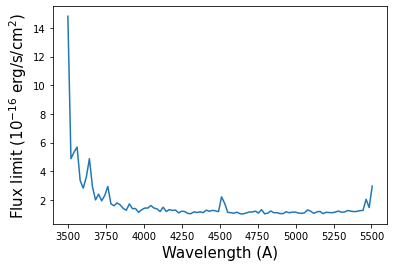

In [16]:
from numpy import linspace
wls = linspace(3500.0, 5505.0, 100)
flims = scube.get_f50(ra, dec, wls, sncut)
plt.plot(wls[flims < 999], flims[flims < 999]*1e16)
plt.xlabel("Wavelength (A)", fontsize=15.0)
plt.ylabel("Flux limit ($10^{-16}$ erg/s/cm$^2$)", fontsize=15.0)

If you want to access the the cube of 50% flux limits you can convert the ```sigmas``` member of the ``SensitivityCube`` class to flux limits via the ```f50_from_noise``` method. For example to plot the flux limit versus ra and dec for the slice at 4750AA we can do

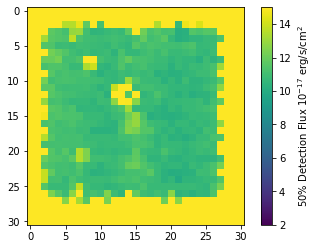

In [17]:
# Use WCS to find correct slice
ix, iy, iz = scube.wcs.all_world2pix(ra, dec, 4750.0, 0)
slice_ = scube.f50_from_noise(scube.sigmas[int(iz), :, :], sncut)
plt.figure()
plt.imshow(slice_*1e17)
plt.colorbar(label="50% Detection Flux $10^{-17}$ erg/s/cm$^2$")
plt.clim(2.0, 15)

Now here is an IFU with some bad data, to demonstrate the mask

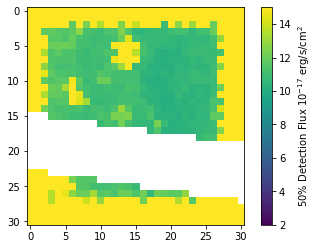

In [18]:
# Use WCS to find correct slice
ix, iy, iz = scube_bad.wcs.all_world2pix(ra, dec, 4750.0, 0)
#from numpy.ma import nomask
#scube_bad.sigmas.mask = nomask
slice_bad = scube_bad.f50_from_noise(scube_bad.sigmas[int(iz), :, :], sncut)
plt.figure()
plt.imshow(slice_bad*1e17)
plt.colorbar(label="50% Detection Flux $10^{-17}$ erg/s/cm$^2$")
plt.clim(2.0, 15)

## Fraction of detected sources versus flux

To get the fraction of sources detected at a particular flux, rather than just the flux limit value one can use this method

In [19]:
# Flux (cgs) RA DEC (in degrees) Wavelength (Angstrom) 
scube.return_completeness(4.1e-17, ra, dec, 4245, sncut)

0.014376673288408248

This completeness is computed using a functional form, this function takes two parameters: the flux limit and a slope which controls how quickly completeness falls off. The latter is fixed to our best guess in this version of the API (**this means it might not be all that accurate!**), in the future this will all be better tested. By definition the flux values from `get_f50` correspond to 50% completeness, i.e.

In [20]:
flux = scube.get_f50(ra, dec, 4245, sncut)
scube.return_completeness(flux, ra, dec, 4245, sncut)

0.5

Here is a plot of the completeness versus flux at some position. Note we use the flux limit computed above to define the range of the plot

Text(0, 0.5, 'Detected Fraction')

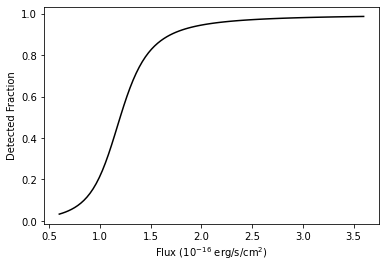

In [21]:
fluxes = linspace(0.5*flux, 3.0*flux, 100)
compl = scube.return_completeness(fluxes, ra, dec, 4245, sncut)
plt.plot(fluxes*1e16, compl, "k-")
plt.xlabel("Flux ($10^{-16}$ erg/s/cm$^2$)")
plt.ylabel("Detected Fraction")

## Looping over all the IFUs in an HDF5 file
If you want to loop over all the IFUs then an iterator is provided. It returns pairs of IFU slot and sensitivity cube. In this example we overplot flux limits for all of the IFUs in the shot

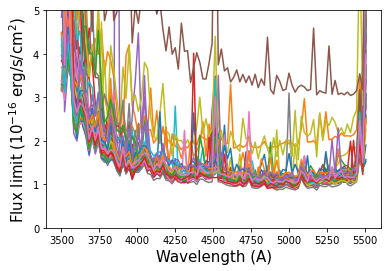

In [22]:
for ifu_name, tscube in hdfcont_hdr2.itercubes():
    
    # Compute the central RA, DEC from the cubes WCS
    shape = tscube.sigmas.shape
    ra, dec, lambda_ = tscube.wcs.all_pix2world(shape[2]/2., shape[1]/2., shape[0]/2., 0)
    
    # Get the flux limits at this RA/DEC and a range of wavelengths
    flims = tscube.get_f50(ra, dec, wls, sncut)
    
    # Plot
    plt.plot(wls[flims < 999], flims[flims < 999]*1e16, label=ifu_name)
    
plt.xlabel("Wavelength (A)", fontsize=15.0)
plt.ylabel("Flux limit ($10^{-16}$ erg/s/cm$^2$)", fontsize=15.0)
plt.ylim(0, 5.0)
plt.show()    